In [1]:
import numpy  as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import scipy.stats

In [2]:
df = pd.read_pickle("/glade/work/hpzhang/LCC_pred/data/data_monthly.pkl").dropna()
df = df[df.index.year.isin(np.arange(2015,2019))]

pred_XGB    = np.load('/glade/work/hpzhang/LCC_pred/data/XGB/y_pred_XGB.npy')
shap_values = np.load('/glade/work/hpzhang/LCC_pred/data/XGB/shap_values.npy')
shap_data   = np.load('/glade/work/hpzhang/LCC_pred/data/XGB/shap_data.npy')

pred_NN  = np.load('/glade/work/hpzhang/LCC_pred/data/NN/y_pred_neural.npy')

pred_Qu    = np.load('/glade/work/hpzhang/LCC_pred/data/Qu/y_pred_lr.npy')

In [3]:
df.head()

,lat,lon,lsm,LCF,T1000,T700,TH1000,TH850,TH700,RH1000,...,LH,SH,SST,Tadv,AOD,dQ,LTS,EIS,ECTEI,ELF
time,,,,,,,,,,,,,,,,,,,,,
2015-01-15,-59.5,0.5,0.0,0.463868,273.248932,257.640778,273.248932,276.122772,285.309723,74.363846,...,-27.085648,-4.329421,273.818970,0.004144,0.1830,0.001957,12.060791,5.536515,4.415848,0.842661
2015-01-15,-59.5,1.5,0.0,0.463868,273.248932,257.677979,273.248932,276.148712,285.350922,74.302193,...,-26.748310,-4.402477,273.810089,0.017093,0.1500,0.001953,12.101990,5.572093,4.453444,0.843229
2015-01-15,-59.5,2.5,0.0,0.429262,273.243439,257.717896,273.243439,276.157379,285.395111,74.627144,...,-25.706528,-3.955046,273.756317,-0.045310,0.1405,0.001963,12.151672,5.616665,4.492636,0.847486
2015-01-15,-59.5,3.5,0.0,0.429262,273.237915,257.761963,273.237915,276.161713,285.443909,74.877113,...,-25.131065,-3.863727,273.736786,-0.162998,0.1455,0.001953,12.205994,5.665254,4.546604,0.851414
2015-01-15,-59.5,4.5,0.0,0.427947,273.237915,257.800537,273.237915,276.212219,285.486633,75.538681,...,-25.160833,-4.320301,273.761627,-0.077789,0.1295,0.001952,12.248718,5.702139,4.584386,0.859509


In [4]:
df_new = pd.DataFrame({'lat':df['lat'],
                       'lon':df['lon'],
                       'LCF':df['LCF'],
                       'EIS':df['EIS'],
                       'ECTEI':df['ECTEI'],
                       'ELF':df['ELF'],
                       'Qu':pred_Qu,
                       'XGBoost':pred_XGB,
                       'NN':pred_NN.flatten(),
                      }, index=df.index)

In [5]:
df_new['season'] = ''
df_new.loc[df_new.index.month.isin([3,4,5]),   'season']='MAM'
df_new.loc[df_new.index.month.isin([6,7,8]),   'season']='JJA'
df_new.loc[df_new.index.month.isin([9,10,11]), 'season']='SON'
df_new.loc[df_new.index.month.isin([12,1,2]),  'season']='DJF'

lat = df_new.lat
lon = df_new.lon

OCN_index = (lat>=-60)&(lat<=60)
SO_index  = (lat>=-60)&(lat<-50)
SEP_index = ((lat>=-20)&(lat<-10)) & ((lon>=270)&(lon<280))
SEA_index = ((lat>=-20)&(lat<-10)) & ((lon>=0)&(lon<10))
SEI_index = ((lat>=-35)&(lat<-25)) & ((lon>=95)&(lon<105))
NEP_index = ((lat>=20)&(lat<30))   & ((lon>=230)&(lon<240))
NEA_index = (lat>=15)&(lat<25)     & ((lon>=325)&(lon<335))
NA_index  = (lat>=50)&(lat<60)     & ((lon>=315)&(lon<325))
NP_index  = (lat>=40)&(lat<50)     & ((lon>=170)&(lon<180))

df_new['regs'] = np.NaN
df_new.loc[SO_index,  'regs']='SO'
df_new.loc[SEP_index, 'regs']='SEP'
df_new.loc[SEA_index, 'regs']='SEA'
df_new.loc[SEI_index, 'regs']='SEI'
df_new.loc[NEP_index, 'regs']='NEP'
df_new.loc[NEA_index, 'regs']='NEA'
df_new.loc[NA_index,  'regs']='NA'
df_new.loc[NP_index,  'regs']='NP'

df_new['season'] = pd.Categorical(df_new['season'], ['DJF', 'MAM', 'JJA', 'SON'])
df_new['regs']   = pd.Categorical(df_new['regs'],   ['NA', 'NP', 'NEP', 'NEA', 'SEP', 'SEA', 'SEI', 'SO'])

In [6]:
df_avg = df_new.groupby(['regs','season']).mean()
df_avg.reset_index(level=[0,1], inplace=True)

In [7]:
plt_all = pd.melt(df_avg, id_vars=['regs','LCF'], value_vars=['EIS','ECTEI','ELF','Qu','XGBoost','NN'],
                  var_name='model', value_name='values')
plt_sub = plt_all[plt_all.regs.isin(['NEP', 'NEA', 'SEP', 'SEA', 'SEI'])]

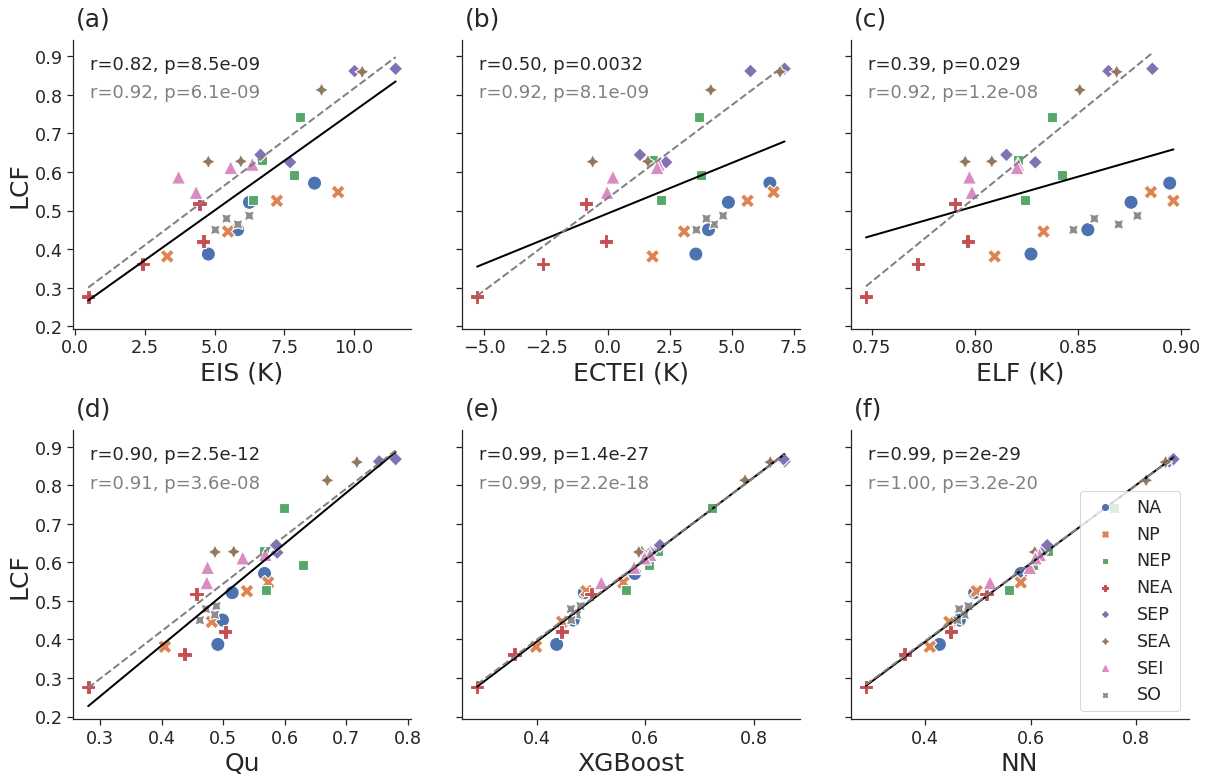

In [8]:

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, font_scale = 1.6)

fig, axes = plt.subplots(2, 3, figsize=[20, 12.5], sharey='all')

model = ['EIS','ECTEI','ELF','Qu','XGBoost','NN']
xlabels = ['EIS (K)','ECTEI (K)','ELF (K)','Qu','XGBoost','NN']
ti = ['(a)','(b)','(c)','(d)','(e)','(f)']

def annotate(data, x, y, ax, **kws):
    r, p = scipy.stats.pearsonr(data['values'], data['LCF'])
    ax.text(x, y, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes, **kws)

for i, ax in enumerate(axes.flat):
      
      ic = i%3
      ir = i//3
      sns.scatterplot(x='values', 
                          y='LCF',
                          data=plt_all[plt_all.model==model[i]],
                          s=200, hue='regs', style='regs',
                          ax=ax)
      sns.regplot(x='values', 
                          y='LCF',
                          data=plt_all[plt_all.model==model[i]],
                          scatter=False,
                          ci=None,
                          line_kws={"color":"black","linestyle":'solid',"lw":2},
                          ax=ax)
      sns.regplot(x='values', 
                          y='LCF',
                          data=plt_sub[plt_sub.model==model[i]],
                          scatter=False,
                          ci=None,
                          line_kws={"color":"grey","linestyle":'dashed',"lw":2},
#                          style='dashed',
                          ax=ax)
      annotate(plt_all[plt_all.model==model[i]], .05, .9, ax, fontsize=18)
      annotate(plt_sub[plt_sub.model==model[i]], .05, .8, ax, color='grey', fontsize=18)
      ax.annotate(ti[i], xy=(0.01, 1.05), xycoords='axes fraction', fontsize=25)
     
      ax.set_xlabel(xlabels[i], fontsize=25)
      ax.set_ylabel('LCF', fontsize=25)
      ax.get_legend().remove()

ax.legend(title = "")    

plt.subplots_adjust(hspace=0.35, wspace=0.15)
plt.show()
